In [2]:
import geopandas as gpd 
import pandas as pd 
import transbigdata as tbd 
import numpy as np 
import shapely
from shapely import Polygon, MultiPolygon, geometry, Point
from pyproj import CRS
from pre_processing import bd_preprocess
import warnings
from PIL import Image
from timezonefinder import TimezoneFinder
import pytz
import suncalc
from suncalc import get_times
import os
import pickle
import pybdshadow
from calendar import monthrange
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [5]:
def generate_grid(bds_aeqd, accuracy):
    lon_start = bds_aeqd.bounds['minx'].min()
    lon_end = bds_aeqd.bounds['maxx'].max()
    lat_start = bds_aeqd.bounds['miny'].min()
    lat_end = bds_aeqd.bounds['maxy'].max()
    # 创建x和y的坐标网格
    x = np.arange(lon_start, lon_end+accuracy, accuracy)  # 因为间隔是-1，所以步长是-1
    y = np.arange(lat_start, lat_end+accuracy, accuracy)
    # 使用meshgrid生成网格
    X, Y = np.meshgrid(x, y)
    grid_list = []
    grid_dict = {}
    for i in range(X.shape[0]-1):
        for j in range(X.shape[1]-1):
            poly1 = Polygon([(X[i][j],Y[i][j]),(X[i][j+1],Y[i][j+1]),(X[i+1][j+1],Y[i+1][j+1]),(X[i+1][j],Y[i+1][j])])
            # 将多边形添加到 GeoDataFrame 中，并设置索引
            grid_list.append(
                {'geometry': poly1, 'grid_id': str(i)+','+str(j)}
            )
            grid_dict[str(i)+','+str(j)] = poly1
    # 使用列表一次性创建 GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(grid_list, crs=bds_aeqd.crs)
    shape = (X.shape[0]-1, X.shape[1]-1)
    return grid_gdf, grid_list, shape

def get_timetable(lon, lat, dates=['2022-06-07'], precision=3600, padding=1800):
    # generate timetable with given interval
    def get_timeSeries(day, lon, lat, precision=3600, padding=1800):
        date = pd.to_datetime(day+' 12:45:33.959797119')
        times = get_times(date, lon, lat)
        date_sunrise = times['sunrise'].value
        date_sunset = times['sunset'].value
        times = pd.to_datetime(pd.Series(range(
            date_sunrise+padding*1000000000,
            date_sunset-padding*1000000000,
            precision*1000000000)))
        return times
    dates = pd.DataFrame(pd.concat(
        [get_timeSeries(date, lon, lat, precision, padding) for date in dates]), columns=['datetime'])
    dates['date'] = dates['datetime'].apply(lambda r: str(r)[:19])
    return dates

In [6]:
def generate_feature(grid, bds_aeqd, shape,column):
    grid_gdf = grid.copy()
    feature = np.zeros((shape[0],shape[1]))
    grid_gdf['centroid'] = grid_gdf['geometry'].apply(lambda gemo: Point(gemo.centroid))
    feature_grid = grid_gdf.copy()
    feature_grid.rename(columns={'geometry':'geometry_1','centroid':'geometry'},inplace=True)
    sjoin = gpd.sjoin(feature_grid,bds_aeqd)
    sjoin.sort_values(by=['grid_id',column],ascending=False,inplace=True)
    sjoin.drop_duplicates(subset=['grid_id'],keep='first',inplace=True)
    for _,row in sjoin.iterrows():
        str_index = row['grid_id']
        x = int(str_index.split(',')[0])
        y = int(str_index.split(',')[1])
        feature[x][y] = row[column]
    sjoin.rename(columns={'geometry':'geometry_2'},inplace=True)
    sjoin.rename(columns={'geometry_1':'geometry'},inplace=True)
    sjoin = gpd.GeoDataFrame(sjoin,geometry='geometry')
    sjoin.crs=bds_aeqd.crs
    return feature, sjoin


In [20]:
bds = gpd.read_file(r'.\buildings\香港_high_500_simplify.geojson')
bds = pybdshadow.bd_preprocess(bds)
center_lon, center_lat =bds.geometry.centroid.x.mean() ,bds.geometry.centroid.y.mean()
epsg = CRS(f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +datum=WGS84")
bds_aeqd = bds.to_crs(epsg)

accuracy = 2
grid_gdf, grid_list, shape = generate_grid(bds_aeqd, accuracy)
# 产生特征数据
feature, feature_gdf = generate_feature(grid_gdf,bds_aeqd,shape,'height')

# 开始生成相应的栅格阴影
tf = TimezoneFinder()
timezone_str = tf.timezone_at(lng=center_lon, lat=center_lat)
timezone = pytz.timezone(timezone_str)
time_table = get_timetable(center_lon,center_lat)
time_table['date'] = pd.to_datetime(time_table['date'])
time_table['local_date'] = time_table['date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
date_time = time_table.iloc[0]['datetime']
shadows = pybdshadow.bdshadow_sunlight(bds,date_time,roof=True,include_building = False)
shadows['shadow'] = 1
shadows = gpd.GeoDataFrame(shadows,geometry='geometry')
shadows = shadows.set_crs(bds.crs)
shadows_aeqd = shadows.to_crs(epsg)
y, y_gdf = generate_feature(grid_gdf,shadows_aeqd,shape,'shadow')

In [24]:
y

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
shadows_aeqd

,height,building_id,geometry,type,shadow
0,3.0,11,"MULTIPOLYGON (((-144.453 209.230, -144.266 208...",roof,1
0,3.0,3,"POLYGON ((14.893 -21.143, 14.895 -21.142, 35.7...",roof,1
1,3.0,6,"POLYGON ((-116.911 40.673, -116.908 40.673, -9...",roof,1
2,3.0,7,"POLYGON ((-119.812 81.608, -119.809 81.608, -1...",roof,1
3,3.0,8,"POLYGON ((-120.892 90.903, -120.890 90.904, -1...",roof,1
...,...,...,...,...,...
62,0.0,62,"MULTIPOLYGON (((-1470.041 -484.701, -1470.040 ...",ground,1
63,0.0,63,"MULTIPOLYGON (((85.730 155.999, 85.733 156.000...",ground,1
64,0.0,64,"MULTIPOLYGON (((-1723.353 -613.040, -1723.351 ...",ground,1
65,0.0,65,"MULTIPOLYGON (((-1852.630 -708.943, -1852.629 ...",ground,1


<Axes: >

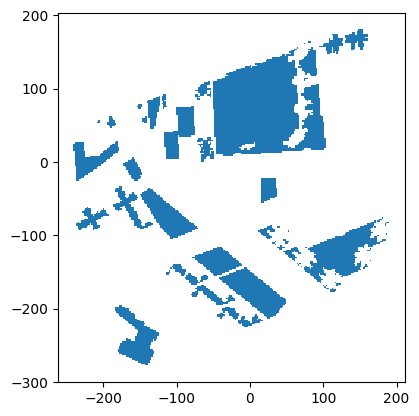

In [31]:
y_gdf_roof = y_gdf[y_gdf['type']=='roof']
y_gdf_roof.plot()

In [62]:
import torch
import torch.nn.functional as F
tensor_y = torch.Tensor(y)
pad_h = 1280- feature.shape[0]
pad_w = 1280 - feature.shape[1]
w1 = int(pad_w/2)
w2 = pad_w-int(pad_w/2)
h1 = int(pad_h/2)
h2 = pad_h-int(pad_h/2)
tensor_y_pad = F.pad(tensor_y,(int(pad_w/2),pad_w-int(pad_w/2),int(pad_h/2),pad_h-int(pad_h/2)))
tensor_y[99,7], tensor_y_pad[99+h1,7+w1]

(tensor(1.), tensor(1.))

In [67]:
def calcluate_position(row, pred,w1,w2,h1,h2):
    grid_id = row['grid_id']
    x, y =int(grid_id.split(',')[0]), int(grid_id.split(',')[1])
    return float(pred[x+h1,y+w1])

In [61]:
y_gdf_roof

,geometry,grid_id,geometry_2,index_right,height,building_id,type,shadow
24926,"POLYGON ((-86.425 -97.192, -84.425 -97.192, -8...","99,77",POINT (-85.425 -96.192),0,9.0,20,roof,1
24925,"POLYGON ((-88.425 -97.192, -86.425 -97.192, -8...","99,76",POINT (-87.425 -96.192),0,9.0,20,roof,1
24924,"POLYGON ((-90.425 -97.192, -88.425 -97.192, -8...","99,75",POINT (-89.425 -96.192),0,9.0,20,roof,1
24923,"POLYGON ((-92.425 -97.192, -90.425 -97.192, -9...","99,74",POINT (-91.425 -96.192),0,9.0,20,roof,1
24922,"POLYGON ((-94.425 -97.192, -92.425 -97.192, -9...","99,73",POINT (-93.425 -96.192),0,9.0,20,roof,1
...,...,...,...,...,...,...,...,...
2560,"POLYGON ((-140.425 -275.192, -138.425 -275.192...","10,50",POINT (-139.425 -274.192),0,15.0,54,roof,1
2559,"POLYGON ((-142.425 -275.192, -140.425 -275.192...","10,49",POINT (-141.425 -274.192),0,15.0,54,roof,1
2558,"POLYGON ((-144.425 -275.192, -142.425 -275.192...","10,48",POINT (-143.425 -274.192),0,15.0,54,roof,1
2557,"POLYGON ((-146.425 -275.192, -144.425 -275.192...","10,47",POINT (-145.425 -274.192),0,15.0,54,roof,1


In [68]:
y_gdf_roof['pred_shaodw'] = y_gdf_roof.apply(lambda x: calcluate_position(x,tensor_y_pad,w1,w2,h1,h2),axis=1)

In [69]:
y_gdf_roof

,geometry,grid_id,geometry_2,index_right,height,building_id,type,shadow,pred_shaodw
24926,"POLYGON ((-86.425 -97.192, -84.425 -97.192, -8...","99,77",POINT (-85.425 -96.192),0,9.0,20,roof,1,1.0
24925,"POLYGON ((-88.425 -97.192, -86.425 -97.192, -8...","99,76",POINT (-87.425 -96.192),0,9.0,20,roof,1,1.0
24924,"POLYGON ((-90.425 -97.192, -88.425 -97.192, -8...","99,75",POINT (-89.425 -96.192),0,9.0,20,roof,1,1.0
24923,"POLYGON ((-92.425 -97.192, -90.425 -97.192, -9...","99,74",POINT (-91.425 -96.192),0,9.0,20,roof,1,1.0
24922,"POLYGON ((-94.425 -97.192, -92.425 -97.192, -9...","99,73",POINT (-93.425 -96.192),0,9.0,20,roof,1,1.0
...,...,...,...,...,...,...,...,...,...
2560,"POLYGON ((-140.425 -275.192, -138.425 -275.192...","10,50",POINT (-139.425 -274.192),0,15.0,54,roof,1,1.0
2559,"POLYGON ((-142.425 -275.192, -140.425 -275.192...","10,49",POINT (-141.425 -274.192),0,15.0,54,roof,1,1.0
2558,"POLYGON ((-144.425 -275.192, -142.425 -275.192...","10,48",POINT (-143.425 -274.192),0,15.0,54,roof,1,1.0
2557,"POLYGON ((-146.425 -275.192, -144.425 -275.192...","10,47",POINT (-145.425 -274.192),0,15.0,54,roof,1,1.0


<Axes: >

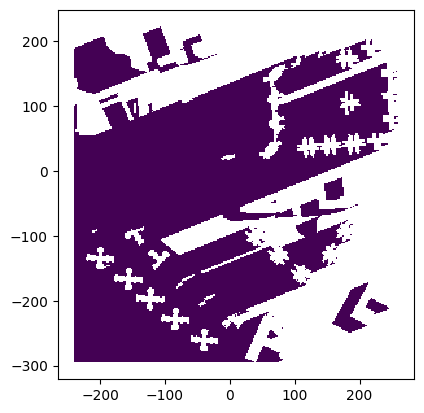

In [28]:
y_gdf.plot(column='shadow')

<Axes: >

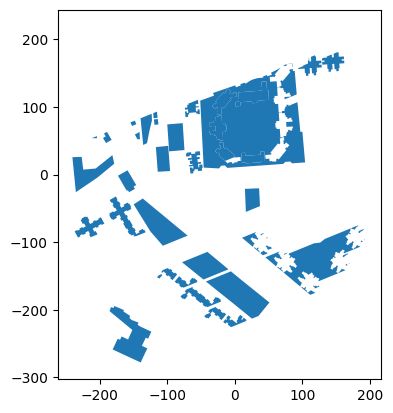

In [35]:
shadows_aeqd_roof = shadows_aeqd[shadows_aeqd['type']=='roof']
shadows_aeqd_roof.plot()

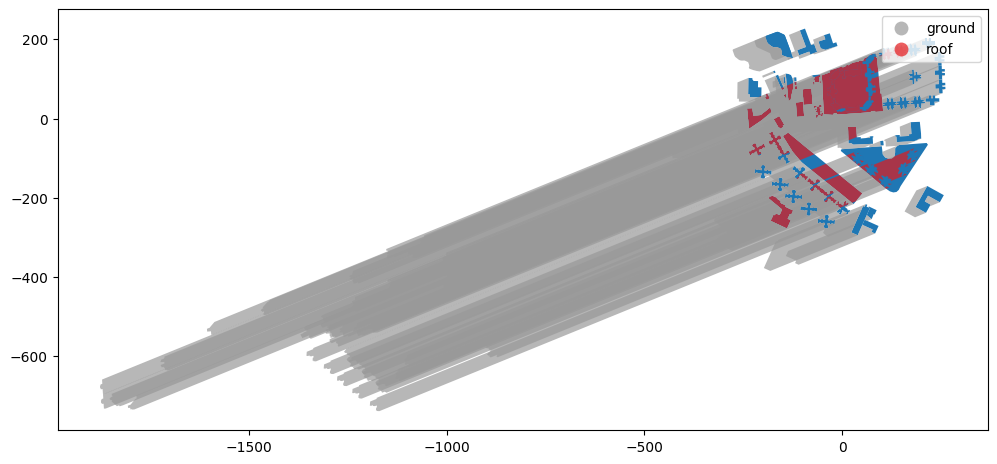

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(1, (12, 12))
ax = plt.subplot(111)

# plot buildings
bds_aeqd.plot(ax=ax)
# plot shadows
# shadows_roof = shadows[shadows['type']=='roof']
shadows_aeqd.plot(ax=ax, alpha=0.7,
             column='type',
             categorical=True,
             cmap='Set1_r',
             legend=True)

plt.show()

KeyError: 'shadow'